##### imports

In [1]:
import allel
import anhima
import h5py
import ingenos
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rpy2
import rpy2.robjects as ro
import scipy
import seaborn as sns
from sklearn import model_selection
%matplotlib inline

##### set base directory

In [2]:
base = "/afs/crc.nd.edu/group/BesanskyNGS/data05/comp_karyo"

##### read in the data

In [3]:
v_2R, g_2R = ingenos.import_data(
    "/afs/crc.nd.edu/group/BesanskyNGS2/inversion_genotyping/merged_p2_and_VObs_2R.h5", "2R")

In [4]:
merged_2R = h5py.File(
    "/afs/crc.nd.edu/group/BesanskyNGS2/inversion_genotyping/merged_p2_and_VObs_2R.h5", 
    mode="r")

gq_2R = merged_2R["2R"]['calldata']['GQ'][:]

##### read in the metadata

In [5]:
md_2R = pd.read_csv(base + "/metadata/all_samples_2R_metadata_annotated_sites_matching_052619.csv",
                    sep="\t")

##### assign taxa

In [6]:
md_2R = md_2R.assign(taxon = pd.Series(md_2R["species"]).values)

md_2R["taxon"].value_counts()

An. gambiae     870
An. coluzzii    341
None            113
hybrid           22
unknown           1
Name: taxon, dtype: int64

In [7]:
md_2R["taxon"] = md_2R["taxon"].map({"An. gambiae" : "An. gambiae",
                    "An. coluzzii" : "An. coluzzii",
                   "None" : "Other",
                   "hybrid" : "Other",
                   "unknown" : "Other"})

md_2R["taxon"].value_counts()

An. gambiae     870
An. coluzzii    341
Other           136
Name: taxon, dtype: int64

In [8]:
md_2R.loc[md_2R["2Rj"] == "2.0","taxon"] = "Bamako"

md_2R["taxon"].value_counts()

An. gambiae     825
An. coluzzii    341
Other           136
Bamako           45
Name: taxon, dtype: int64

##### merge computational and cytogenetic karyotypes for c, d, j, and u

In [9]:
md_2R["2Rd_merged"] = md_2R["new_PCA_2Rd"]

md_2R.loc[md_2R["new_PCA_2Rd"] == "None","2Rd_merged"] =\
md_2R.loc[md_2R["new_PCA_2Rd"] == "None","2Rd"]

In [10]:
md_2R["2Rj_merged"] = md_2R["new_PCA_2Rj"]

md_2R.loc[md_2R["new_PCA_2Rj"] == "None","2Rj_merged"] =\
md_2R.loc[md_2R["new_PCA_2Rj"] == "None","2Rj"]

In [11]:
md_2R["2Rc_merged"] = md_2R["new_PCA_2Rc"]

md_2R.loc[md_2R["new_PCA_2Rc"] == "None","2Rc_merged"] =\
md_2R.loc[md_2R["new_PCA_2Rc"] == "None","2Rc"]

md_2R["2Rc_merged"] =\
pd.Series(pd.to_numeric(md_2R["2Rc_merged"], errors='coerce')).map(float)

In [12]:
md_2R["2Ru_merged"] = md_2R["new_PCA_2Ru"]

md_2R.loc[md_2R["new_PCA_2Ru"] == "None","2Ru_merged"] =\
md_2R.loc[md_2R["new_PCA_2Ru"] == "None","2Ru"]

md_2R["2Ru_merged"] =\
pd.Series(pd.to_numeric(md_2R["2Ru_merged"], errors='coerce')).map(float)

In [13]:
md_2R["2Rc_merged"].fillna(value="None", inplace=True)
md_2R["2Ru_merged"].fillna(value="None", inplace=True)

In [14]:
md_2R["2Rd_merged"].value_counts()

0.0     818
None    455
1.0      40
2.0      34
Name: 2Rd_merged, dtype: int64

In [15]:
md_2R["2Rc_merged"].value_counts()

0.0     995
None    171
2.0      92
1.0      89
Name: 2Rc_merged, dtype: int64

In [16]:
md_2R["2Ru_merged"].value_counts()

0.0     1073
None     171
2.0       56
1.0       47
Name: 2Ru_merged, dtype: int64

In [17]:
md_2R["2Rj_merged"].value_counts()

0.0     843
None    455
2.0      45
1.0       4
Name: 2Rj_merged, dtype: int64

##### create sites filters

##### 2Rj

In [18]:
two_Rj_sites = ingenos.construct_filter_expression(
    "2Rj",ingenos.inversionDict,buffer=5000)

In [19]:
two_Rj_sites

'( ( (POS > 3257186) & (POS < 3267296) ) |        ( (POS > 15745716) & (POS < 15755717) ) )'

In [20]:
two_Rj_bool = v_2R.eval(two_Rj_sites)

In [21]:
np.sum(two_Rj_bool)

7793

##### 2Rd

In [22]:
bp_2Rd = (31495381, 42375004)

[(bp - 15000, bp + 15000) for bp in bp_2Rd]

[(31480381, 31510381), (42360004, 42390004)]

In [23]:
two_Rd_sites =\
'( ( ( POS > 31480381 ) & ( POS < 31510381 ) ) | ( ( POS > 42360004 ) & ( POS < 42390004 ) ) )'

In [24]:
two_Rd_bool = v_2R.eval(two_Rd_sites)

In [25]:
np.sum(two_Rd_bool)

5621

##### 2Ru

In [26]:
two_Ru_sites = ingenos.construct_filter_expression(
    "2Ru",ingenos.inversionDict,buffer=5000)

In [27]:
two_Ru_sites

'( ( (POS > 31468000) & (POS < 31488751) ) |        ( (POS > 35499441) & (POS < 35510236) ) )'

In [28]:
two_Ru_bool = v_2R.eval(two_Ru_sites)

In [29]:
np.sum(two_Ru_bool)

6330

##### make trees

In [30]:
country_colors = {}

for index, country in enumerate(md_2R["country"].unique()):
    
    country_colors[country] = matplotlib.colors.to_hex(cm.tab20.colors[index])

In [31]:
inv_colors = {'0.0': "red", '1.0' : "purple", '2.0' : "blue", "None" : "grey"}

In [32]:
inv_int_colors = {'0': "red", '1' : "purple", '2' : "blue", "None" : "grey"}

In [33]:
taxon_colors = {"Bamako" : "forestgreen", "An. coluzzii" : "orange", "An. gambiae" : "black",
               "Other" : "yellow"}

In [34]:
##in general, these things come in two flavors: a list of values (country, inversion,
# taxon, whatever), and a list of corresponding colors or symbols

##this is just circles for all specimens
sample_symbols = [u'\u25CF'] * len(md_2R)
##specimen names
sample_labels = list(md_2R["ox_code"].values)

##this is the appropriate taxon-based color for each specimen, no matter the inversion
taxon_colors_specimens = [taxon_colors[s] for s in md_2R["taxon"].values]
##the appropriate country-based color for each specimen, no matter the inversion
country_colors_specimens = [country_colors[s] for s in md_2R["country"].values]

##this is the taxon values and country values for each specimen, no matter the inversion
taxon_values = list(md_2R["taxon"].values)
country_values = list(md_2R["country"].values)

##### 2Rj

In [35]:
two_Rj_num_alt_alleles, two_Rj_which_alleles = ingenos.filter_and_convert_genotypes(
    g_2R, sites_boolean = two_Rj_bool,
    min_count = 1, variance_threshold = 0.01)

In [36]:
_, two_Rj_dist_mat = anhima.dist.pairwise_distance(two_Rj_num_alt_alleles, metric="euclidean")

In [37]:
two_Rj_num_alt_alleles.shape

(909, 1347)

##### 2Rj-specific aesthetics

In [38]:
j_values = list(md_2R["2Rj_merged"].values)
inv_colors_j = [inv_colors[p] for p in md_2R["2Rj_merged"].values]

In [39]:
two_Rj_tree = anhima.tree.nj(two_Rj_dist_mat, list(md_2R["ox_code"].values))

In [40]:
inv_edge_colors_j = anhima.tree.color_edges_by_group_majority(two_Rj_tree, 
                                                        labels=sample_labels, 
                                                        groups=j_values, 
                                                        colors=inv_colors)

In [41]:
tax_edge_colors_j = anhima.tree.color_edges_by_group_majority(two_Rj_tree, 
                                                        labels=sample_labels, 
                                                        groups=taxon_values, 
                                                        colors=taxon_colors)

In [42]:
country_edge_colors_j = anhima.tree.color_edges_by_group_majority(two_Rj_tree, 
                                                        labels=sample_labels, 
                                                        groups=country_values, 
                                                        colors=country_colors)

In [43]:
two_Rj_tree[2] = ro.StrVector(sample_symbols)

##### 2Rd

In [44]:
two_Rd_num_alt_alleles, two_Rd_which_alleles = ingenos.filter_and_convert_genotypes(
    g_2R, sites_boolean = two_Rd_bool,
    min_count = 1, variance_threshold = 0.01)

In [45]:
_, two_Rd_dist_mat = anhima.dist.pairwise_distance(two_Rd_num_alt_alleles, metric="euclidean")

In [46]:
two_Rd_num_alt_alleles.shape

(955, 1347)

##### 2Rd-specific aesthetics

In [47]:
d_values = list(md_2R["2Rd_merged"].values)
inv_colors_d = [inv_colors[p] for p in md_2R["2Rd_merged"].values]

In [48]:
two_Rd_tree = anhima.tree.nj(two_Rd_dist_mat, list(md_2R["ox_code"].values))

In [49]:
inv_edge_colors_d = anhima.tree.color_edges_by_group_majority(two_Rd_tree, 
                                                        labels=sample_labels, 
                                                        groups=d_values, 
                                                        colors=inv_colors)

In [50]:
tax_edge_colors_d = anhima.tree.color_edges_by_group_majority(two_Rd_tree, 
                                                        labels=sample_labels, 
                                                        groups=taxon_values, 
                                                        colors=taxon_colors)

In [51]:
country_edge_colors_d = anhima.tree.color_edges_by_group_majority(two_Rd_tree, 
                                                        labels=sample_labels, 
                                                        groups=country_values, 
                                                        colors=country_colors)

In [52]:
two_Rd_tree[2] = ro.StrVector(sample_symbols)

##### and 2Ru

In [53]:
two_Ru_num_alt_alleles, two_Ru_which_alleles = ingenos.filter_and_convert_genotypes(
    g_2R, sites_boolean = two_Ru_bool,
    min_count = 1, variance_threshold = 0.01)

In [54]:
_, two_Ru_dist_mat = anhima.dist.pairwise_distance(two_Ru_num_alt_alleles, metric="euclidean")

In [55]:
two_Ru_num_alt_alleles.shape

(1110, 1347)

##### 2Ru-specific aesthetics

In [56]:
u_values = list(md_2R["2Ru_merged"].map(str).values)
inv_colors_u = [inv_colors[p] for p in md_2R["2Ru_merged"].map(str)]

In [57]:
two_Ru_tree = anhima.tree.nj(two_Ru_dist_mat, list(md_2R["ox_code"].values))

In [58]:
inv_edge_colors_u = anhima.tree.color_edges_by_group_majority(two_Ru_tree, 
                                                        labels=sample_labels, 
                                                        groups=u_values, 
                                                        colors=inv_colors)

In [59]:
tax_edge_colors_u = anhima.tree.color_edges_by_group_majority(two_Ru_tree, 
                                                        labels=sample_labels, 
                                                        groups=taxon_values, 
                                                        colors=taxon_colors)

In [60]:
country_edge_colors_u = anhima.tree.color_edges_by_group_majority(two_Ru_tree, 
                                                        labels=sample_labels, 
                                                        groups=country_values, 
                                                        colors=country_colors)

In [61]:
two_Ru_tree[2] = ro.StrVector(sample_symbols)

##### read in data for 2L, and do other three inversions

In [62]:
path_2L = "/afs/crc.nd.edu/group/BesanskyNGS2/inversion_genotyping/merged_p2_and_VObs_2L.h5"
chrom_2L = "2L"

callset_2L = h5py.File(path_2L, mode="r")[chrom_2L]

v_2L = allel.VariantChunkedTable(callset_2L['variants'], index='POS',
                                names=['POS','REF','ALT','DP','MQ','QD','numalt'])

g_2L = allel.GenotypeChunkedArray(callset_2L['calldata']['GT'])

md_2L = pd.read_csv(base + "/metadata/all_samples_2L_metadata_annotated_sites_matching_051019.csv",
                    sep="\t")

In [63]:
md_2L = md_2L.assign(taxon = pd.Series(md_2L["species"]).values)

md_2L["taxon"].value_counts()

An. gambiae     870
An. coluzzii    341
None            113
hybrid           22
unknown           1
Name: taxon, dtype: int64

In [64]:
md_2L["taxon"] = md_2L["taxon"].map({"An. gambiae" : "An. gambiae",
                    "An. coluzzii" : "An. coluzzii",
                   "None" : "Other",
                   "hybrid" : "Other",
                   "unknown" : "Other"})

md_2L.loc[md_2L["2Rj"] == "2.0","taxon"] = "Bamako"

md_2L["taxon"].value_counts()

An. gambiae     825
An. coluzzii    341
Other           136
Bamako           45
Name: taxon, dtype: int64

##### create additional sites filters

In [65]:
two_Rc_sites = ingenos.construct_filter_expression(
    "2Rc",ingenos.inversionDict,buffer=5000)

In [66]:
two_Rc_sites

'( ( (POS > 26745000) & (POS < 26789943) ) |        ( (POS > 31445000) & (POS < 31478100) ) )'

In [67]:
two_Rc_bool = v_2R.eval(two_Rc_sites)

In [68]:
np.sum(two_Rc_bool)

11366

In [69]:
two_Rb_sites = ingenos.construct_filter_expression(
    "2Rb",ingenos.inversionDict,buffer=5000)

In [70]:
two_Rb_sites

'( ( (POS > 19018925) & (POS < 19032916) ) |        ( (POS > 26742166) & (POS < 26763676) ) )'

In [71]:
two_Rb_bool = v_2R.eval(two_Rb_sites)
np.sum(two_Rb_bool)

2845

In [72]:
two_La_sites = ingenos.construct_filter_expression(
    "2La",ingenos.inversionDict,buffer=5000)

In [73]:
two_La_sites

'( ( (POS > 20519058) & (POS < 20533089) ) |        ( (POS > 42160182) & (POS < 42170532) ) )'

In [74]:
two_La_bool = v_2L.eval(two_La_sites)
np.sum(two_La_bool)

3734

##### 2Rc

In [75]:
two_Rc_num_alt_alleles, two_Rc_which_alleles = ingenos.filter_and_convert_genotypes(
    g_2R, sites_boolean = two_Rc_bool,
    min_count = 1, variance_threshold = 0.01)

In [76]:
_, two_Rc_dist_mat = anhima.dist.pairwise_distance(two_Rc_num_alt_alleles, metric="euclidean")

In [77]:
two_Rc_dist_mat.shape

(1347, 1347)

In [78]:
two_Rc_num_alt_alleles.shape

(2141, 1347)

##### 2Rc-specific aesthetics

In [79]:
c_values = list(md_2R["2Rc_merged"].map(str).values)
inv_colors_c = [inv_colors[p] for p in md_2R["2Rc_merged"].map(str).values]

In [80]:
two_Rc_tree = anhima.tree.nj(two_Rc_dist_mat, list(md_2R["ox_code"].values))

In [81]:
inv_edge_colors_c = anhima.tree.color_edges_by_group_majority(two_Rc_tree, 
                                                        labels=sample_labels, 
                                                        groups=c_values, 
                                                        colors=inv_colors)

In [82]:
tax_edge_colors_c = anhima.tree.color_edges_by_group_majority(two_Rc_tree, 
                                                        labels=sample_labels, 
                                                        groups=taxon_values, 
                                                        colors=taxon_colors)

In [83]:
country_edge_colors_c = anhima.tree.color_edges_by_group_majority(two_Rc_tree, 
                                                        labels=sample_labels, 
                                                        groups=country_values, 
                                                        colors=country_colors)

In [84]:
two_Rc_tree[2] = ro.StrVector(sample_symbols)

##### 2Rb

In [85]:
two_Rb_num_alt_alleles, two_Rb_which_alleles = ingenos.filter_and_convert_genotypes(
    g_2R, sites_boolean = two_Rb_bool,
    min_count = 1, variance_threshold = 0.01)

In [86]:
_, two_Rb_dist_mat = anhima.dist.pairwise_distance(two_Rb_num_alt_alleles, metric="euclidean")

In [87]:
two_Rb_num_alt_alleles.shape

(428, 1347)

##### 2Rb-specific aesthetics

In [88]:
b_values = list(md_2R["new_PCA_2Rb"].values)
inv_colors_b = [inv_colors[p] for p in md_2R["new_PCA_2Rb"].values]

In [89]:
two_Rb_tree = anhima.tree.nj(two_Rb_dist_mat, list(md_2R["ox_code"].values))

In [90]:
inv_edge_colors_b = anhima.tree.color_edges_by_group_majority(two_Rb_tree, 
                                                        labels=sample_labels, 
                                                        groups=b_values, 
                                                        colors=inv_colors)

In [91]:
tax_edge_colors_b = anhima.tree.color_edges_by_group_majority(two_Rb_tree, 
                                                        labels=sample_labels, 
                                                        groups=taxon_values, 
                                                        colors=taxon_colors)

In [92]:
country_edge_colors_b = anhima.tree.color_edges_by_group_majority(two_Rb_tree, 
                                                        labels=sample_labels, 
                                                        groups=country_values, 
                                                        colors=country_colors)

In [93]:
two_Rb_tree[2] = ro.StrVector(sample_symbols)

##### finally, 2La, which also requires 2L-specific aesthetics

In [94]:
two_La_num_alt_alleles, two_La_which_alleles = ingenos.filter_and_convert_genotypes(
    g_2L, sites_boolean = two_La_bool,
    min_count = 1, variance_threshold = 0.01)

In [95]:
_, two_La_dist_mat = anhima.dist.pairwise_distance(two_La_num_alt_alleles, metric="euclidean")

In [96]:
two_La_num_alt_alleles.shape

(596, 1347)

In [97]:
##circles
sample_symbols_2L = [u'\u25CF'] * len(md_2L)
##specimen names
sample_labels_2L = list(md_2L["ox_code"].values)

##taxon color for each specimen
taxon_colors_specimens_2L = [taxon_colors[s] for s in md_2L["taxon"].values]
##country color for each specimens
country_colors_specimens_2L = [country_colors[s] for s in md_2L["country"].values]

##taxon values and country values
taxon_values_2L = list(md_2L["taxon"].values)
country_values_2L = list(md_2L["country"].values)

In [98]:
a_values = list(md_2L["new_PCA_2La"].map(float).map(str).values)
inv_colors_a = [inv_colors[p] for p in md_2L["new_PCA_2La"].map(float).map(str).values]

In [99]:
two_La_tree = anhima.tree.nj(two_La_dist_mat, list(md_2L["ox_code"].values))

In [100]:
inv_edge_colors_a = anhima.tree.color_edges_by_group_majority(two_La_tree, 
                                                        labels=sample_labels_2L, 
                                                        groups=a_values, 
                                                        colors=inv_colors)

In [101]:
tax_edge_colors_a = anhima.tree.color_edges_by_group_majority(two_La_tree, 
                                                        labels=sample_labels_2L, 
                                                        groups=taxon_values_2L, 
                                                        colors=taxon_colors)

In [102]:
country_edge_colors_a = anhima.tree.color_edges_by_group_majority(two_La_tree, 
                                                        labels=sample_labels_2L, 
                                                        groups=country_values_2L, 
                                                        colors=country_colors)

In [103]:
two_La_tree[2] = ro.StrVector(sample_symbols_2L)

##### plot

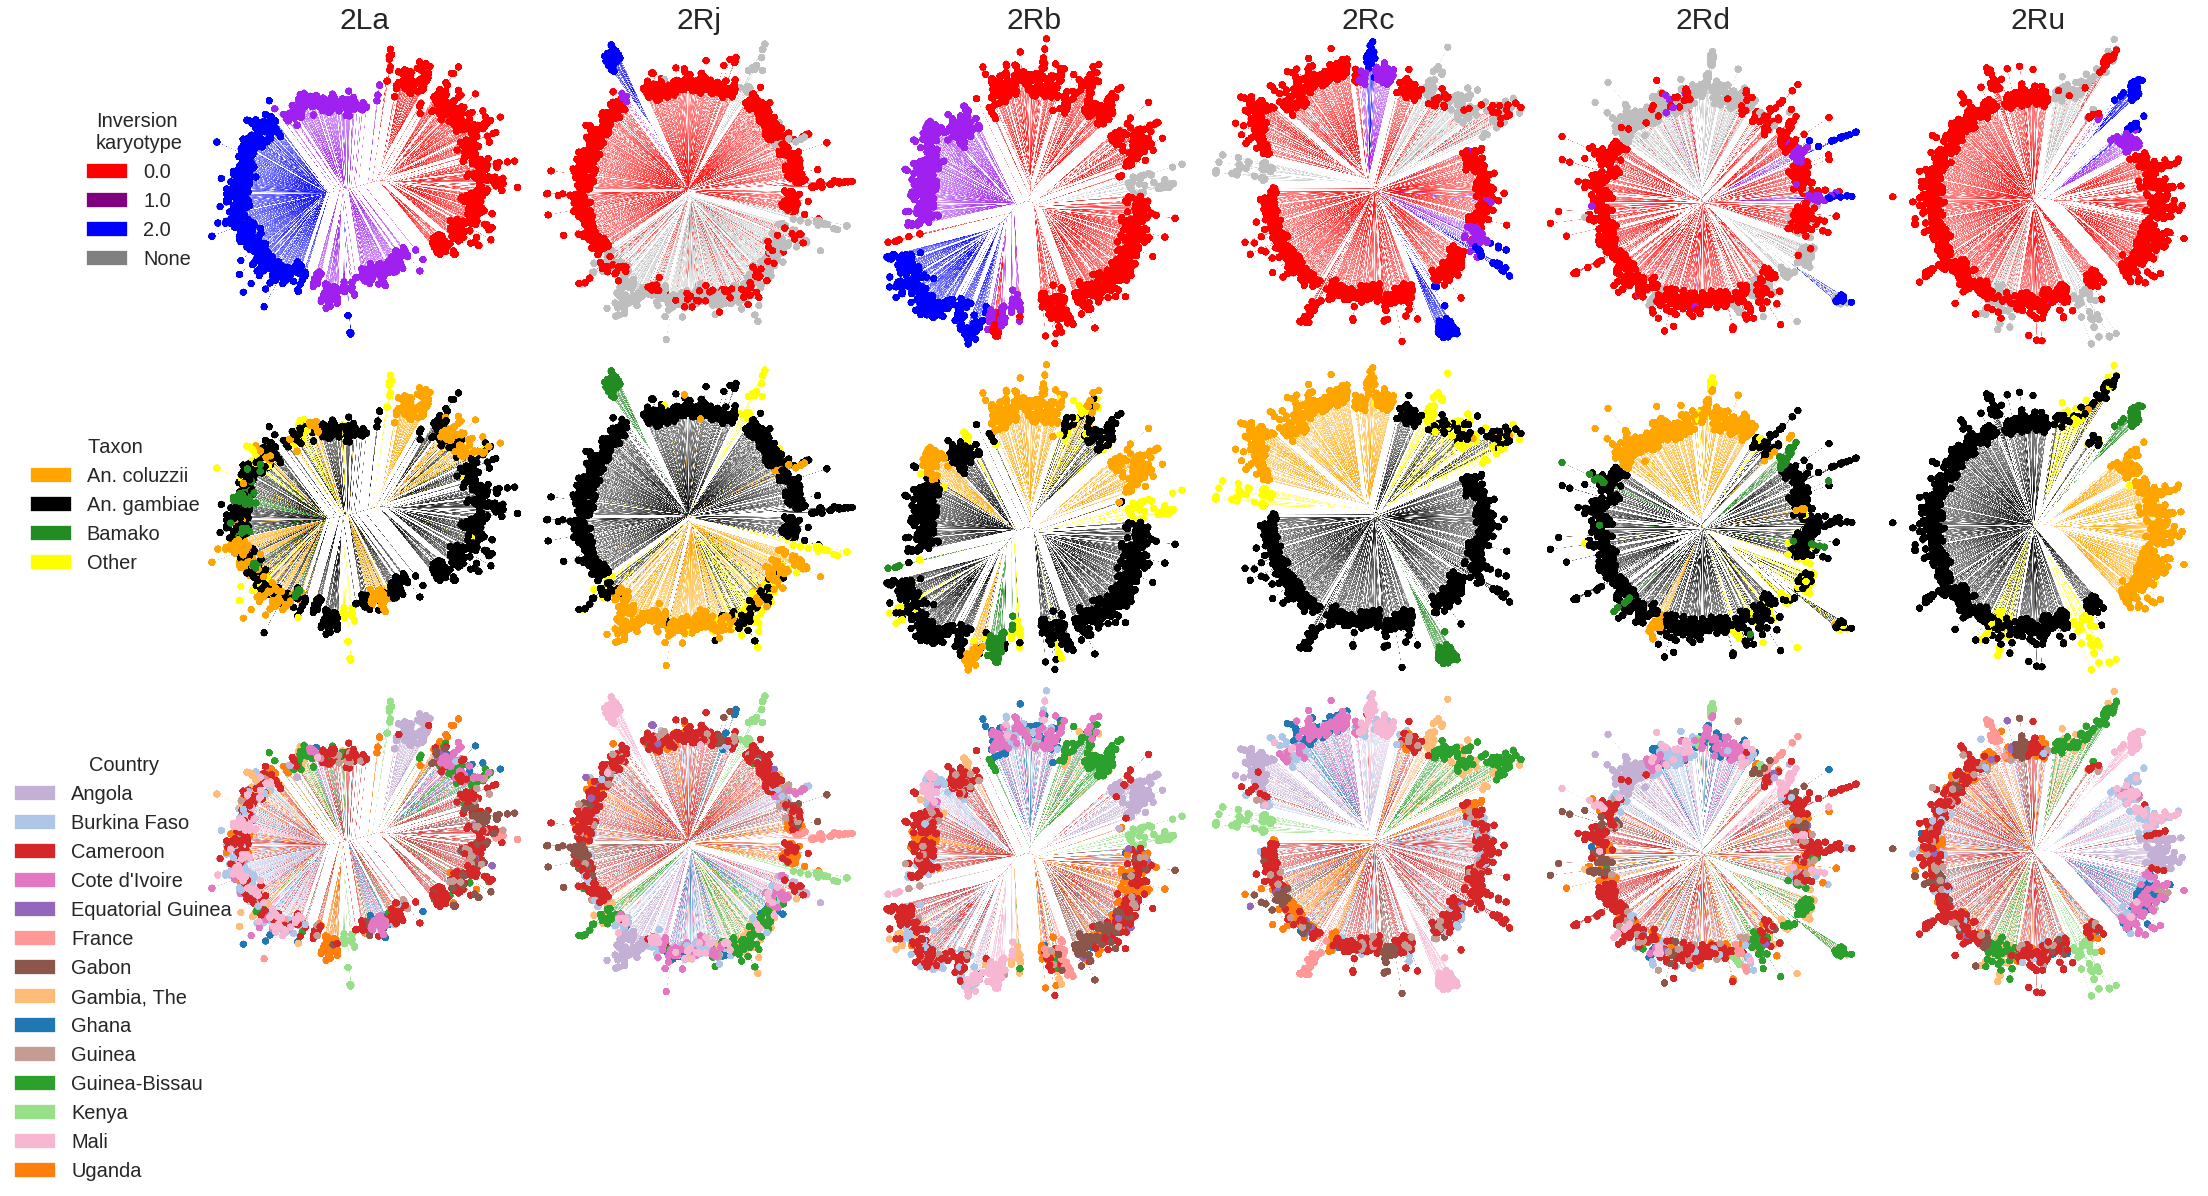

In [104]:
fig, axes = plt.subplots(nrows=3, ncols=6, figsize = (36, 18))
plt.subplots_adjust(wspace=0, hspace=0)

##2La
anhima.tree.plot_phylo(two_La_tree, ax=axes[0,0], plot_kwargs={'type': 'unrooted', 
                                                        'tip.color': inv_colors_a, 
                                                        'show.tip.label' : True,
                                                        'edge.color': inv_edge_colors_a,
                                                       'edge.width' : .10,
                                                        'lab4ut' : 'axial',
                                                        'no.margin' : True,
                                                       'cex' : .75}, 
                       width=6, height=6, units = "cm", res=500)

anhima.tree.plot_phylo(two_La_tree, ax=axes[1,0], plot_kwargs={'type': 'unrooted', 
                                                        'tip.color': taxon_colors_specimens_2L, 
                                                        'show.tip.label' : True,
                                                        'edge.color': tax_edge_colors_a,
                                                       'edge.width' : .10,
                                                        'lab4ut' : 'axial',
                                                        'no.margin' : True,
                                                       'cex' : .75}, 
                       width=6, height=6, units = "cm", res=500)

anhima.tree.plot_phylo(two_La_tree, ax=axes[2,0], plot_kwargs={'type': 'unrooted', 
                                                        'tip.color': \
                                                               country_colors_specimens_2L, 
                                                        'show.tip.label' : True,
                                                        'edge.color': country_edge_colors_a,
                                                       'edge.width' : .10,
                                                        'lab4ut' : 'axial',
                                                        'no.margin' : True,
                                                       'cex' : .75}, 
                       width=6, height=6, units = "cm", res=500)

##2Rj
anhima.tree.plot_phylo(two_Rj_tree, ax=axes[0,1], plot_kwargs={'type': 'unrooted', 
                                                        'tip.color': inv_colors_j, 
                                                        'show.tip.label' : True,
                                                        'edge.color': inv_edge_colors_j,
                                                       'edge.width' : .10,
                                                        'lab4ut' : 'axial',
                                                        'no.margin' : True,
                                                       'cex' : .75}, 
                       width=6, height=6, units = "cm", res=500)

anhima.tree.plot_phylo(two_Rj_tree, ax=axes[1,1], plot_kwargs={'type': 'unrooted', 
                                                        'tip.color': taxon_colors_specimens, 
                                                        'show.tip.label' : True,
                                                        'edge.color': tax_edge_colors_j,
                                                       'edge.width' : .10,
                                                        'lab4ut' : 'axial',
                                                        'no.margin' : True,
                                                       'cex' : .75}, 
                       width=6, height=6, units = "cm", res=500)

anhima.tree.plot_phylo(two_Rj_tree, ax=axes[2,1], plot_kwargs={'type': 'unrooted', 
                                                        'tip.color': \
                                                               country_colors_specimens, 
                                                        'show.tip.label' : True,
                                                        'edge.color': country_edge_colors_j,
                                                       'edge.width' : .10,
                                                        'lab4ut' : 'axial',
                                                        'no.margin' : True,
                                                       'cex' : .75}, 
                       width=6, height=6, units = "cm", res=500)



##2Rb
anhima.tree.plot_phylo(two_Rb_tree, ax=axes[0,2], plot_kwargs={'type': 'unrooted', 
                                                        'tip.color': inv_colors_b, 
                                                        'show.tip.label' : True,
                                                        'edge.color': inv_edge_colors_b,
                                                       'edge.width' : .10,
                                                        'lab4ut' : 'axial',
                                                        'no.margin' : True,
                                                       'cex' : .75}, 
                       width=6, height=6, units = "cm", res=500)

anhima.tree.plot_phylo(two_Rb_tree, ax=axes[1,2], plot_kwargs={'type': 'unrooted', 
                                                        'tip.color': taxon_colors_specimens, 
                                                        'show.tip.label' : True,
                                                        'edge.color': tax_edge_colors_b,
                                                       'edge.width' : .10,
                                                        'lab4ut' : 'axial',
                                                        'no.margin' : True,
                                                       'cex' : .75}, 
                       width=6, height=6, units = "cm", res=500)

anhima.tree.plot_phylo(two_Rb_tree, ax=axes[2,2], plot_kwargs={'type': 'unrooted', 
                                                        'tip.color': \
                                                               country_colors_specimens, 
                                                        'show.tip.label' : True,
                                                        'edge.color': country_edge_colors_b,
                                                       'edge.width' : .10,
                                                        'lab4ut' : 'axial',
                                                        'no.margin' : True,
                                                       'cex' : .75}, 
                       width=6, height=6, units = "cm", res=500)

##2Rc
anhima.tree.plot_phylo(two_Rc_tree, ax=axes[0,3], plot_kwargs={'type': 'unrooted', 
                                                        'tip.color': inv_colors_c, 
                                                        'show.tip.label' : True,
                                                        'edge.color': inv_edge_colors_c,
                                                       'edge.width' : .10,
                                                        'lab4ut' : 'axial',
                                                        'no.margin' : True,
                                                       'cex' : .75}, 
                       width=6, height=6, units = "cm", res=500)

anhima.tree.plot_phylo(two_Rc_tree, ax=axes[1,3], plot_kwargs={'type': 'unrooted', 
                                                       'tip.color': taxon_colors_specimens, 
                                                        'show.tip.label' : True,
                                                        'edge.color': tax_edge_colors_c,
                                                       'edge.width' : .10,
                                                        'lab4ut' : 'axial',
                                                        'no.margin' : True,
                                                       'cex' : .75}, 
                       width=6, height=6, units = "cm", res=500)

anhima.tree.plot_phylo(two_Rc_tree, ax=axes[2,3], plot_kwargs={'type': 'unrooted', 
                                                       'tip.color': \
                                                               country_colors_specimens, 
                                                        'show.tip.label' : True,
                                                        'edge.color': country_edge_colors_c,
                                                       'edge.width' : .10,
                                                        'lab4ut' : 'axial',
                                                        'no.margin' : True,
                                                       'cex' : .75}, 
                       width=6, height=6, units = "cm", res=500)

##2Rd
anhima.tree.plot_phylo(two_Rd_tree, ax=axes[0,4], plot_kwargs={'type': 'unrooted', 
                                                        'tip.color': inv_colors_d, 
                                                        'show.tip.label' : True,
                                                        'edge.color': inv_edge_colors_d,
                                                       'edge.width' : .10,
                                                        'lab4ut' : 'axial',
                                                        'no.margin' : True,
                                                       'cex' : .75}, 
                       width=6, height=6, units = "cm", res=500)

anhima.tree.plot_phylo(two_Rd_tree, ax=axes[1,4], plot_kwargs={'type': 'unrooted', 
                                                        'tip.color': taxon_colors_specimens, 
                                                        'show.tip.label' : True,
                                                        'edge.color': tax_edge_colors_d,
                                                       'edge.width' : .10,
                                                        'lab4ut' : 'axial',
                                                        'no.margin' : True,
                                                       'cex' : .75}, 
                       width=6, height=6, units = "cm", res=500)

anhima.tree.plot_phylo(two_Rd_tree, ax=axes[2,4], plot_kwargs={'type': 'unrooted', 
                                                        'tip.color': \
                                                               country_colors_specimens, 
                                                        'show.tip.label' : True,
                                                        'edge.color': country_edge_colors_d,
                                                       'edge.width' : .10,
                                                        'lab4ut' : 'axial',
                                                        'no.margin' : True,
                                                       'cex' : .75}, 
                       width=6, height=6, units = "cm", res=500)

##2Ru
anhima.tree.plot_phylo(two_Ru_tree, ax=axes[0,5], plot_kwargs={'type': 'unrooted', 
                                                        'tip.color': inv_colors_u, 
                                                        'show.tip.label' : True,
                                                        'edge.color': inv_edge_colors_u,
                                                       'edge.width' : .10,
                                                        'lab4ut' : 'axial',
                                                        'no.margin' : True,
                                                       'cex' : .75}, 
                       width=6, height=6, units = "cm", res=500)

anhima.tree.plot_phylo(two_Ru_tree, ax=axes[1,5], plot_kwargs={'type': 'unrooted', 
                                                       'tip.color': taxon_colors_specimens, 
                                                        'show.tip.label' : True,
                                                        'edge.color': tax_edge_colors_u,
                                                       'edge.width' : .10,
                                                        'lab4ut' : 'axial',
                                                        'no.margin' : True,
                                                       'cex' : .75}, 
                       width=6, height=6, units = "cm", res=500)

anhima.tree.plot_phylo(two_Ru_tree, ax=axes[2,5], plot_kwargs={'type': 'unrooted', 
                                                       'tip.color': \
                                                               country_colors_specimens, 
                                                        'show.tip.label' : True,
                                                        'edge.color': country_edge_colors_u,
                                                       'edge.width' : .10,
                                                        'lab4ut' : 'axial',
                                                        'no.margin' : True,
                                                       'cex' : .75}, 
                       width=6, height=6, units = "cm", res=500)

##add titles
axes[0,0].set_title("2La", fontsize=30)
axes[0,0].title.set_position([0.5, 0.98])
axes[0,1].set_title("2Rj", fontsize=30)
axes[0,1].title.set_position([0.5, 0.98])
axes[0,2].set_title("2Rb", fontsize=30)
axes[0,2].title.set_position([0.5, 0.98])
axes[0,3].set_title("2Rc", fontsize=30)
axes[0,3].title.set_position([0.5, 0.98])
axes[0,4].set_title("2Rd", fontsize=30)
axes[0,4].title.set_position([0.5, 0.98])
axes[0,5].set_title("2Ru", fontsize=30)
axes[0,5].title.set_position([0.5, 0.98])

##add legends
taxon_handles = list()
for taxon in sorted(taxon_colors.keys()):
    patch = matplotlib.patches.Patch(color=taxon_colors[taxon], label=taxon)
    taxon_handles.append(patch)

inv_handles = list()
for inv in sorted(inv_colors.keys()):
    patch = matplotlib.patches.Patch(color=inv_colors[inv], label=inv)
    inv_handles.append(patch)
    
country_handles = list()

for country in sorted(country_colors.keys()):
    patch = matplotlib.patches.Patch(color=country_colors[country], label=country)
    country_handles.append(patch)

first_legend = axes[0,0].legend(handles = inv_handles, bbox_to_anchor=(.025, .8), 
                         title='Inversion\nkaryotype', fontsize=20)
first_legend.get_title().set_fontsize('20')

second_legend = axes[1,0].legend(handles=taxon_handles, bbox_to_anchor=(.05, .8), 
               title='Taxon', fontsize=20)
second_legend.get_title().set_fontsize('20')

third_legend = axes[2,0].legend(handles=country_handles, bbox_to_anchor=(.15, .825), 
               title='Country', fontsize=20)
third_legend.get_title().set_fontsize('20')

outString = ingenos.make_date_stamp(
    "../data/results/comp_aim1/2La2Rjbcdu_breakpoints_all_specimens_nj_tree_three_rows")

plt.savefig(outString, bbox_inches="tight");

##### double check the number of sites that went into each tree

In [105]:
np.sum(two_La_which_alleles)

596

In [106]:
np.sum(two_Rb_which_alleles)

428

In [107]:
np.sum(two_Rc_which_alleles)

2141

In [108]:
np.sum(two_Rd_which_alleles)

955

In [109]:
np.sum(two_Rj_which_alleles)

909

In [110]:
np.sum(two_Ru_which_alleles)

1110